We will use the test/train/val datasets to train one model, and next we will split sentimentdataset into test/train/val to train a different model, then compare model performances.

In [39]:
import pandas as pd

df = pd.read_csv("train.csv")

df.dropna(inplace=True)

df["Addicted"] = (df["Daily_Usage_Time (minutes)"] > 120).astype(int)

count_more_than_120 = df["Addicted"].sum()
count_less_than_120 = (df["Addicted"] == 0).sum()

print(df[["Daily_Usage_Time (minutes)", "Age", "Gender", "Addicted"]].head())
print(f"Number of people with Daily Usage Time greater than 120 minutes: {count_more_than_120}")
print(f"Number of people with Daily Usage Time less than or equal to 120 minutes: {count_less_than_120}")


   Daily_Usage_Time (minutes) Age      Gender  Addicted
0                       120.0  25      Female         0
1                        90.0  30        Male         0
2                        60.0  22  Non-binary         0
3                       200.0  28      Female         1
4                        45.0  33        Male         0
Number of people with Daily Usage Time greater than 120 minutes: 220
Number of people with Daily Usage Time less than or equal to 120 minutes: 780


float64
               Age  Daily_Usage_Time (minutes)  Posts_Per_Day  \
count  1000.000000                 1000.000000    1000.000000   
mean     27.510000                   95.950000       3.321000   
std       3.930057                   38.850442       1.914582   
min      21.000000                   40.000000       1.000000   
25%      24.000000                   65.000000       2.000000   
50%      27.500000                   85.000000       3.000000   
75%      30.250000                  120.000000       4.000000   
max      35.000000                  200.000000       8.000000   

       Likes_Received_Per_Day  Comments_Received_Per_Day  \
count             1000.000000                1000.000000   
mean                39.898000                  15.611000   
std                 26.393867                   8.819493   
min                  5.000000                   2.000000   
25%                 20.000000                   8.000000   
50%                 33.000000                 

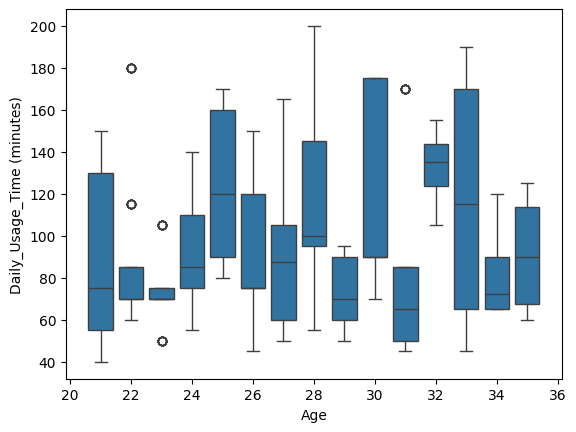

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

print(df['Age'].dtype)
# print(len(df.loc[df["Gender"]=="Male"]))
# print(len(df.loc[df["Age"]=="Male"]))
print(df.describe())

ax = sns.boxplot(x=df["Age"], y=df["Daily_Usage_Time (minutes)"], native_scale=True)
#ax.axvline(25, color=".3", dashes=(2, 2))


In [19]:
import pandas as pd

df = pd.read_csv('train.csv')
known_genders = ["Male", "Female", "Non-binary"]
swapped_rows = df['Age'].astype(str).isin(known_genders)

#swap Age and Gender where needed
df.loc[swapped_rows, ['Age', 'Gender']] = df.loc[swapped_rows, ['Gender', 'Age']].values

#Age --> numeric and  invalid values --> NaN
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')


#new cleaned file
df.to_csv('train_cleaned.csv', index=False)
print(df[swapped_rows])

    User_ID   Age      Gender   Platform  Daily_Usage_Time (minutes)  \
250     251  27.0        Male  Instagram                       165.0   
251     252  24.0      Female    Twitter                        75.0   
252     253  29.0  Non-binary   Facebook                        85.0   
253     254  33.0      Female  Instagram                       145.0   
254     255  31.0        Male   LinkedIn                        60.0   
..      ...   ...         ...        ...                         ...   
784     784  22.0        Male    Twitter                        70.0   
785     785  29.0  Non-binary   Facebook                        75.0   
786     786  28.0      Female   Whatsapp                       100.0   
787     787  31.0        Male   Telegram                        85.0   
788     788  21.0  Non-binary   Snapchat                        60.0   

     Posts_Per_Day  Likes_Received_Per_Day  Comments_Received_Per_Day  \
250            6.0                    85.0                    

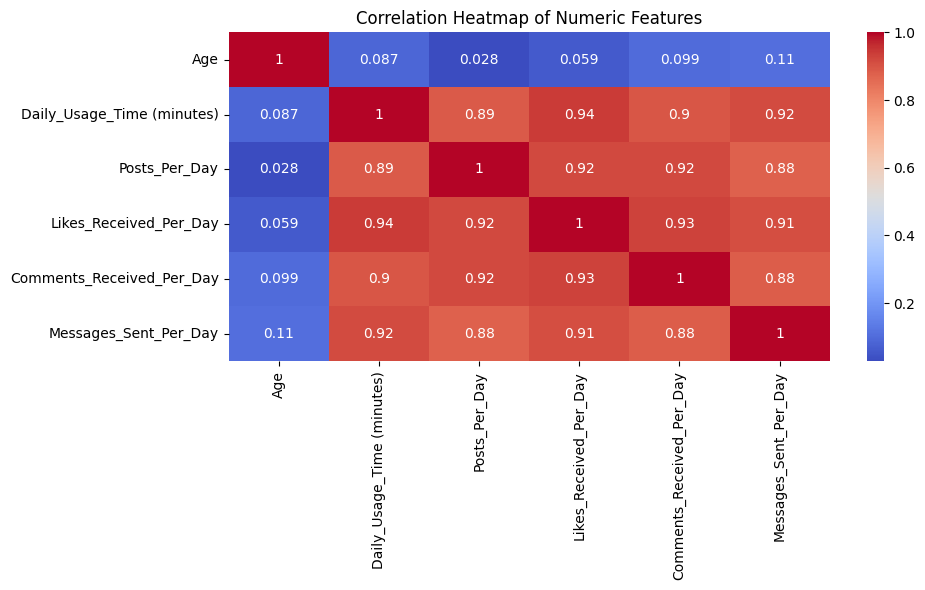

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Select only numeric columns
numeric_df = df.select_dtypes(include='number')

# Step 2: Compute correlation matrix
corr_matrix = numeric_df.corr()

# Step 3: Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

In [30]:
print(df.columns)

Index(['User_ID', 'Age', 'Gender', 'Platform', 'Daily_Usage_Time (minutes)',
       'Posts_Per_Day', 'Likes_Received_Per_Day', 'Comments_Received_Per_Day',
       'Messages_Sent_Per_Day', 'Dominant_Emotion', 'Addicted'],
      dtype='object')


In [31]:

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

scaler = StandardScaler()

X = df[["Posts_Per_Day", "Likes_Received_Per_Day", "Comments_Received_Per_Day"]]
X_scaled = scaler.fit_transform(X)
y = df["Addicted"]
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.33, random_state = 42)

#Try a few different classification models to classify addicted/not addicted

#K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

#Random Forest
forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
forest.fit(X_train, y_train)
y_pred_forest = forest.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_forest))
print(classification_report(y_test, y_pred_forest))

#Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9939393939393939
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       257
           1       1.00      0.97      0.99        73

    accuracy                           0.99       330
   macro avg       1.00      0.99      0.99       330
weighted avg       0.99      0.99      0.99       330

Accuracy: 0.996969696969697
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       257
           1       1.00      0.99      0.99        73

    accuracy                           1.00       330
   macro avg       1.00      0.99      1.00       330
weighted avg       1.00      1.00      1.00       330

Logistic Regression Accuracy: 0.9878787878787879
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       257
           1       0.97      0.97      0.97        73

    accuracy                           0.99       330
   macro avg       0.9

In [ ]:
import pandas as pd

df = pd.read_csv("C:/Users/gresn/OneDrive/CSDS312/ProjectFiles/sentimentdataset.csv")

df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Date"] = df["Timestamp"].dt.date

#group by user and date
user_daily_activity = df.groupby(["User", "Date"]).agg(
    total_posts=("Text", "count"),
    total_likes=("Likes", "sum"),
    total_retweets=("Retweets", "sum"),
    first_post=("Timestamp", "min"),
    last_post=("Timestamp", "max"),
).reset_index()

#time on app = timestamp of last post - timestamp of first post (each post takes 15 mins)
user_daily_activity["Active_Hours"] = (user_daily_activity["last_post"] - user_daily_activity["first_post"]).dt.total_seconds() / 3600
user_daily_activity["Active_Hours"].fillna(0, inplace=True)
user_daily_activity["Daily_Usage_Time"] = user_daily_activity["total_posts"] * 15 / 60

#total interactions = likes + retweets
user_daily_activity["Total_Interactions"] = user_daily_activity["total_likes"] + user_daily_activity["total_retweets"]

#addiction = over 2 hours of usage OR over 100 interactions per day
user_daily_activity["Addicted"] = ((user_daily_activity["Daily_Usage_Time"] > 2) | (user_daily_activity["Total_Interactions"] > 100)).astype(int)

df = df.merge(user_daily_activity[["User", "Date", "Addicted"]], on=["User", "Date"], how="left")
df.dropna(inplace=True)
print(df[["User", "Date", "Addicted"]].head())

print("Number of addicted users:", df["Addicted"].sum())
total_users = df["User"].nunique()
print("Total number of users:", total_users)

             User        Date  Addicted
0   User123        2023-01-15         0
1   CommuterX      2023-01-15         0
2   FitnessFan     2023-01-15         0
3   AdventureX     2023-01-15         0
4   ChefCook       2023-01-15         0
Number of addicted users: 105
Total number of users: 685


In [32]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


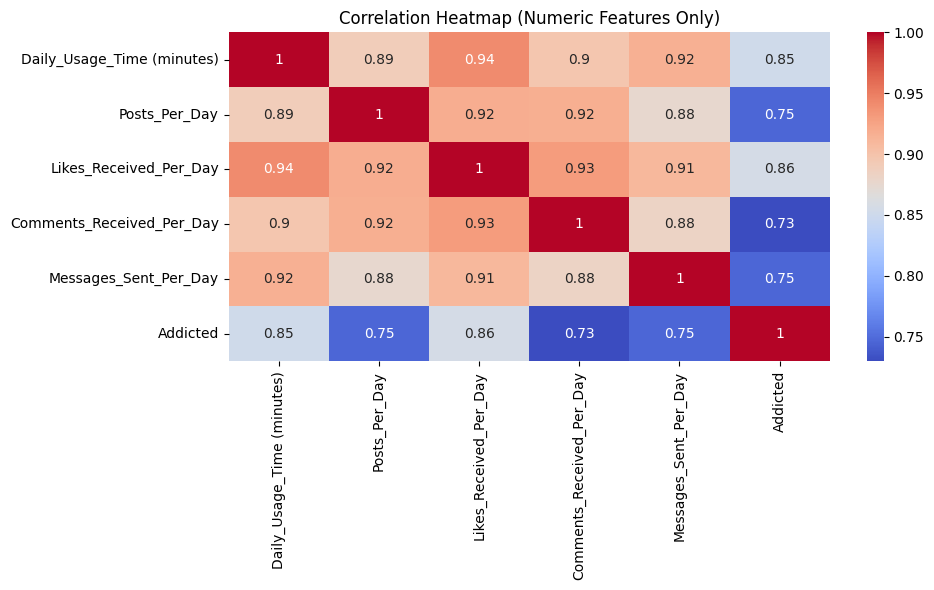

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Only select numeric columns for correlation
numeric_df = df.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.tight_layout()
plt.show()

In [36]:
print(df.columns)

Index(['User_ID', 'Age', 'Gender', 'Platform', 'Daily_Usage_Time (minutes)',
       'Posts_Per_Day', 'Likes_Received_Per_Day', 'Comments_Received_Per_Day',
       'Messages_Sent_Per_Day', 'Dominant_Emotion', 'Addicted'],
      dtype='object')


In [40]:
#Models for First Dataset

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

#Define variables for training and testing
#Features based only on user behavior
scaler = StandardScaler()

X = df[["Posts_Per_Day", "Likes_Received_Per_Day", "Comments_Received_Per_Day"]]
X_scaled = scaler.fit_transform(X)
y = df["Addicted"]
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.33, random_state = 42)

#Try a few different classification models to classify addicted/not addicted

#K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

#Random Forest
forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
forest.fit(X_train, y_train)
y_pred_forest = forest.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_forest))
print(classification_report(y_test, y_pred_forest))

#Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9939393939393939
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       257
           1       1.00      0.97      0.99        73

    accuracy                           0.99       330
   macro avg       1.00      0.99      0.99       330
weighted avg       0.99      0.99      0.99       330

Accuracy: 0.996969696969697
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       257
           1       1.00      0.99      0.99        73

    accuracy                           1.00       330
   macro avg       1.00      0.99      1.00       330
weighted avg       1.00      1.00      1.00       330

Logistic Regression Accuracy: 0.9878787878787879
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       257
           1       0.97      0.97      0.97        73

    accuracy                           0.99       330
   macro avg       0.9